# Brute-Force Hyperparameter Optimization

This notebook shows how to use the *BruteForce* optimizer module together with a **Midi2Vec** *Pipeline* to evaluate a large number of *Encoder* and *SequenceLearner* hyperparameter combinations against a given training set.

* **Encoder**: trains a *Doc2Vec* model against textual representations of MIDI files and uses this model to convert MIDI files into sequences of real-valued vectors.
* **SequenceLearner**: uses a *Keras* LSTM to learn patterns in sequences of real-valued vectors and, once trained, can generate new sequences of such vectors.
* **Pipeline**: combines various **Midi2Vec** components for encoding, sequence learning and evaluation into a single interface.
* **BruteForce**: Computes and evaluates all possible hyperparameter combinations within user-specified ranges.

## Imports

In [1]:
import sys
import time
import logging
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import math
import itertools

# Add Midi2Vec to Python working directory
sys.path.append('../')

from data_loading import MidiDataLoader
from midi_to_dataframe import NoteMapper
from pipeline import Pipeline
from optimization import BruteForce

/usr/local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


## Logging Configuration

In [2]:
logger = logging.getLogger()
logger.level = logging.INFO
stream_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stream_handler)

# Disable Gensim (Doc2Vec) output
logging.getLogger("gensim").setLevel(logging.WARNING)

## Brute-Force Hyperparameter Sweep Values

All individual hyperparameter values to evaluate should be explicitly defined below. The *BruteForce* module will then compute all of their possible permutations and train and evaluate the corresponding modules using each computed set of parameters.

In [3]:
# Documents used to train semantic encoder model
encoder_training_docs = "../../midi-embeddings/data/full_1_measure.txt"
#encoder_training_docs = "../resources/encoder_training_docs/full_1_measure.txt"
#encoder_training_docs = "../../midi-embeddings/data/full_1_measure_100k.txt"

param_sweep_values = {

    # Encoder (doc2vec) settings:
    'doc2vec_docs': [encoder_training_docs],
    'doc2vec_dm': [1],
    'doc2vec_dm_mean': [1],
    'doc2vec_epochs': [1],
    'doc2vec_hs': [0],
    'doc2vec_learning_rate_start': [0.025],
    'doc2vec_learning_rate_end': [0.2],
    'doc2vec_min_count': [8],
    'doc2vec_negative': [0],
    'doc2vec_vector_size': [20],
    'doc2vec_window': [4],

    # Sequence learning (Keras LSTM) settings:
    'nn_features': [
        ['bpm', 'measure', 'beat']
    ],
    'nn_batch_size': [32],
    'nn_dense_activation_function': ["linear"],
    'nn_dropout': [0],
    'nn_epochs': [16],
    'nn_hidden_neurons': [32],
    'nn_layers': [16],
    'nn_lstm_activation_function': ["selu"],
    'nn_lstm_n_prev': [16],
    'nn_loss': [
        'mean_squared_error',
        'mean_absolute_error',
        'mean_absolute_percentage_error',
        'mean_squared_logarithmic_error',
        'squared_hinge',
        'hinge',
        'categorical_hinge',
        'logcosh',
        'categorical_crossentropy',
        'sparse_categorical_crossentropy',
        'binary_crossentropy',
        'kullback_leibler_divergence',
        'cosine_proximity'
    ],
    'nn_optimizer': [
        'sgd',
        'rmsprop',
        'adagrad',
        'adadelta',
        'adam',
        'adamax',
        'nadam'
    ]
}

# 'Variables' are those hyperparameters with multiple values defined
variables = []
for key, value in param_sweep_values.items():
    if len(value) > 1:
        variables.append(key)

## Define Training Documents and DataLoader 

The training documents are MIDI sequences that the **Midi2Vec** model should learn to imitate and reproduce.

In [4]:
# Define note mapper for MIDI file loading
note_mapping_config_path = "../settings/map-to-group.json"
note_mapper = NoteMapper(note_mapping_config_path)

# Data loader used to encode MIDI-format training files
data_loader = MidiDataLoader(note_mapper)

# Define training documents for sequence learning
training_docs = ["../resources/midi/system_shock/cyberspace_clip_16.mid",
                "../resources/midi/system_shock/end_remix_clip_16.mid",
                "../resources/midi/system_shock/energy_clip_16.mid",
                "../resources/midi/system_shock/security_bridge_clip_16.mid"]

training_docs = ["../resources/midi/breakbeats/084 Breakthru.mid",
                 "../resources/midi/breakbeats/086 Clouds.mid",
                 "../resources/midi/breakbeats/089 Get Out.mid",
                 "../resources/midi/breakbeats/089 Wrong.mid",
                 "../resources/midi/breakbeats/090 Deceive.mid",
                 "../resources/midi/breakbeats/090 New York.mid",
                 "../resources/midi/breakbeats/090 Radio.mid",
                 "../resources/midi/breakbeats/093 Pretender.mid",
                 "../resources/midi/breakbeats/093 Right Won.mid",
                 "../resources/midi/breakbeats/094 Run.mid"]

training_docs = ["../resources/midi/jungle/160 Jungle 05.mid",
                 "../resources/midi/jungle/160 Jungle 11.mid",
                 "../resources/midi/jungle/170 Jungle 01.mid",
                 "../resources/midi/jungle/170 Jungle 03.mid",
                 "../resources/midi/jungle/170 Jungle 04.mid",
                 "../resources/midi/jungle/170 Jungle 06.mid",
                 "../resources/midi/jungle/170 Jungle 07.mid",
                 "../resources/midi/jungle/170 Jungle 08.mid",
                 "../resources/midi/jungle/170 Jungle 09.mid",
                 "../resources/midi/jungle/170 Jungle 10.mid",
                 "../resources/midi/jungle/170 Jungle 12.mid",
                 "../resources/midi/jungle/170 Jungle 13.mid",
                 "../resources/midi/jungle/170 Jungle 14.mid",
                 "../resources/midi/jungle/170 Jungle 15.mid",
                 "../resources/midi/jungle/170 Jungle 16.mid",
                 "../resources/midi/jungle/180 Jungle 02.mid"]

## Define Callback Function

This function is called after every iteration of *SequenceLearner* model training. It controls outputting intermediary results and can trigger early stopping of the evaluation pipeline. Since the space of all hyperparameter combinations to evaluate can be exponentially large, it can make sense to implement reasonable early stopping criteria, i.e. after a given number of single evaluations or a predetermined amount of time.

In [5]:
results_dfs = []
runs_completed = [0]
start_time = time.time()
hours = 0.5
max_runtime = hours*60*60

def callback(params, metrics, abort):
    runs_completed[0] += 1
    merged = {**params, **metrics}
    merged['nn_features'] = ', '.join(merged['nn_features'])
    print("Completed " + str(runs_completed[0]) + " runs.")
    print(merged)
    results_dfs.append(pd.DataFrame(merged, index=[0]))
    elapsed_time = time.time() - start_time
    print(str(elapsed_time) + " seconds elapsed so far.")
    if elapsed_time >= max_runtime:
        print("Max. runtime reached.")
        abort()

## Build and Run the Pipeline

In [6]:
pipeline = Pipeline()
pipeline.set_data_loader(data_loader)
pipeline.set_training_docs(training_docs)
pipeline.set_k_fold_cross_eval(k=4)

brute_force_param_sweep = BruteForce(params=param_sweep_values)
brute_force_param_sweep.set_callback(callback)
brute_force_param_sweep.save_best_model("models", "jungle")
pipeline.set_optimizer(brute_force_param_sweep)

pipeline.run()

Brute-force evaluation of 91 hyperparameter combinations.
Loaded 100000 documents
Loaded 200000 documents
Loaded 300000 documents
Loaded 400000 documents
Loaded 500000 documents
Loaded 600000 documents
Loaded 700000 documents
Loaded 800000 documents
Loaded 900000 documents
Loaded 1000000 documents
Loaded 1100000 documents
Loaded 1200000 documents
Loaded 1300000 documents
Loaded 1400000 documents
Loaded 1500000 documents
Loaded 1600000 documents
Loaded 1700000 documents
Training encoder model...
Trained encoder model in 142.57660293579102 seconds
Training and evaluating fold 1 of 4.
Trained sequence learning model in 53.9521279335022 seconds
Trained and evaluated fold 1 of sequence model in 87.82664895057678 seconds.
Training and evaluating fold 2 of 4.
Trained sequence learning model in 56.97877502441406 seconds
Trained and evaluated fold 2 of sequence model in 58.677119970321655 seconds.
Training and evaluating fold 3 of 4.
Trained sequence learning model in 55.9173378944397 seconds
T

,doc2vec_dm,doc2vec_dm_mean,doc2vec_docs,doc2vec_epochs,doc2vec_hs,doc2vec_learning_rate_end,doc2vec_learning_rate_start,doc2vec_min_count,doc2vec_negative,doc2vec_vector_size,...,nn_epochs,nn_features,nn_hidden_neurons,nn_layers,nn_loss,nn_lstm_activation_function,nn_lstm_n_prev,nn_optimizer,precision,recall
0,1,1,../../midi-embeddings/data/full_1_measure.txt,1,0,0.2,0.025,8,0,20,...,16,"[bpm, measure, beat]",32,16,logcosh,selu,16,nadam,0.327758,0.267717
1,1,1,../../midi-embeddings/data/full_1_measure.txt,1,0,0.2,0.025,8,0,20,...,16,"[bpm, measure, beat]",32,16,logcosh,selu,16,adam,0.330896,0.291904
2,1,1,../../midi-embeddings/data/full_1_measure.txt,1,0,0.2,0.025,8,0,20,...,16,"[bpm, measure, beat]",32,16,categorical_crossentropy,selu,16,adadelta,0.087743,0.168466
3,1,1,../../midi-embeddings/data/full_1_measure.txt,1,0,0.2,0.025,8,0,20,...,16,"[bpm, measure, beat]",32,16,categorical_hinge,selu,16,adagrad,0.269744,0.359688
4,1,1,../../midi-embeddings/data/full_1_measure.txt,1,0,0.2,0.025,8,0,20,...,16,"[bpm, measure, beat]",32,16,mean_squared_error,selu,16,sgd,0.095238,0.112163


## Collect and Aggregate Results of Runs 

In [7]:
results_df = pd.concat(results_dfs)

# Alternatively: load previous results to inspect
# results_df = pd.read_csv('breakbeats_2018_06_03.csv')
# TODO read 'variables' from DF if using saved CSV

## Graph Single Variables (F1 Scores)

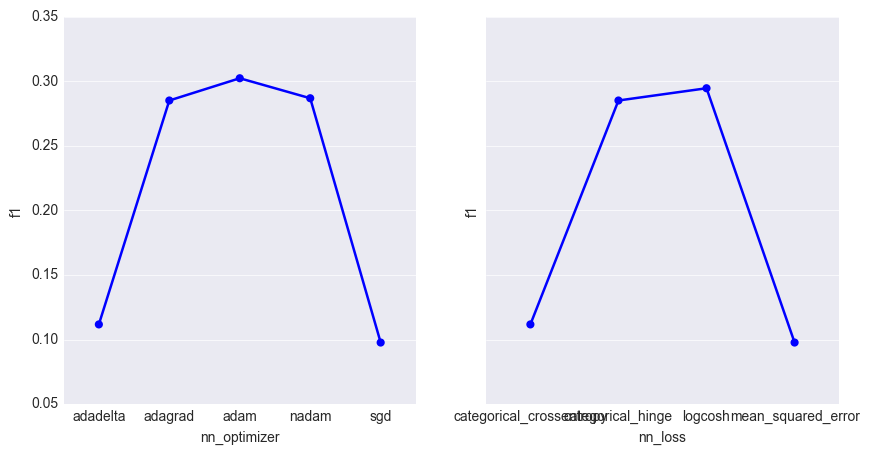

In [8]:
sns.set_style("darkgrid")

# Get number of plots to create
num_plots = len(variables)       
dim = math.ceil(num_plots / 2)

# Set up figures for plots
fig, axes = plt.subplots(dim, 2, sharex=False, sharey=True)
fig.set_size_inches(10, dim*5) # width, height

for axis_index, variable in enumerate(variables):
    grouped = results_df[[variable,'f1']].groupby([variable], as_index=False).median()
    sns.pointplot(x=variable, y='f1', data=grouped, ax=axes.flat[axis_index])

## Graph Variable Interactions (F1 Scores)

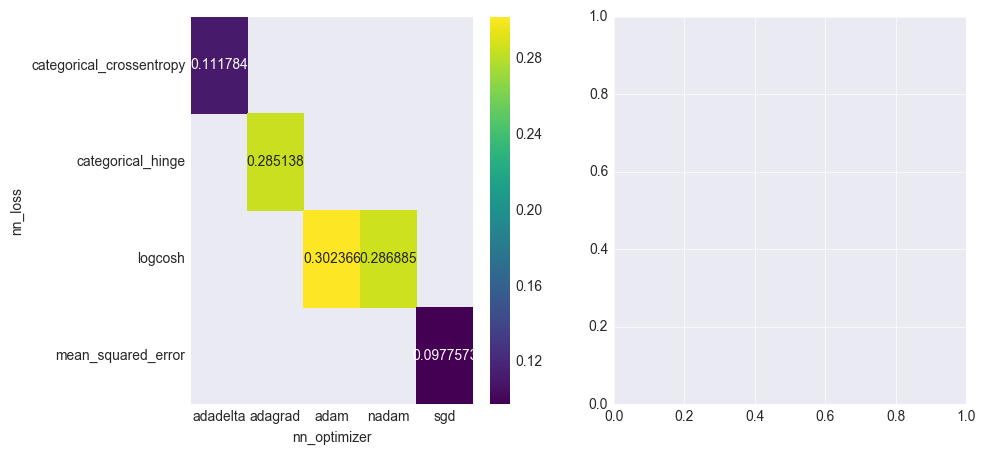

In [9]:
combinations = list(itertools.combinations(variables, r=2))
plots_per_row = 2
inches_per_plot = 5

# Number of plots to render
num_plots = len(combinations)            
dim = math.ceil(num_plots / plots_per_row)

# Set up figures for plots
fig, axes = plt.subplots(dim, plots_per_row, sharex=False, sharey=False)
fig.set_size_inches(plots_per_row * inches_per_plot, dim * inches_per_plot) # width, height

# Plot each pair of variables against each other on a heatmap
for axis_index, (heatmap_x, heatmap_y) in enumerate(combinations):
    grouped = results_df.groupby([heatmap_y, heatmap_x], as_index=False).median()
    pivoted = grouped.pivot(heatmap_y, heatmap_x, "f1")
    sns.heatmap(pivoted, annot=True, fmt="g", cmap='viridis', ax=axes.flat[axis_index])
    axis_index += 1

## Store Results of Evaluation Run

In [10]:
#results_df.to_csv("breakbeats_2018_06_03.csv")